In [3]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
!pip install fredapi

In [10]:
import yfinance as yf
import pandas_datareader as pdr
from fredapi import Fred
import pandas as pd


fred = Fred(api_key='2b89a22a93a46a84fb958d90e54465cc')



def filter_dates(df):
    df = df[df.index >= '2010-01-01']
    df = df[~((df.index >= '2020-01-01') & (df.index < '2022-01-01'))]
    return df


start_date = '2010-01-01'
end_date = '2019-12-31'
start_date_2 = '2022-01-01'

# Get copper prices (从yfinance)
copper = fred.get_series('PCOPPUSDM', observation_start='2010-01-01')
copper = copper.to_frame(name='Copper_Spot_Price')
#copper_monthly = copper.resample('MS').mean().dropna()
copper_monthly = filter_dates(copper)
copper_monthly['Copper_Spot_Price_lb'] = copper_monthly['Copper_Spot_Price'] / 2204.62

# 2. Get USD Index
usd_index = yf.download('DX-Y.NYB', start='2010-01-01')
usd_index = usd_index[['Close']].rename(columns={'Close': 'USD_Index'})
usd_index_monthly = usd_index.resample('MS').mean().dropna()
usd_index_monthly = filter_dates(usd_index_monthly)

# Get Fed Funds Rate
fed_funds = fred.get_series('FEDFUNDS').to_frame(name='Fed_Funds_Rate')

# Get CPI
cpi = fred.get_series('CPIAUCSL').to_frame(name='CPI')

# Get oil prices
oil = fred.get_series('DCOILWTICO').to_frame(name='Oil_Price_WTI')
oil_monthly = oil.resample('MS').mean().dropna()
oil_monthly = filter_dates(oil_monthly)



fed_funds = filter_dates(fed_funds)
cpi = filter_dates(cpi)





df_combined = copper_monthly.join([usd_index_monthly, fed_funds, cpi, oil_monthly], how='outer')
print("\nCombined data shape:", df_combined.shape)
print(df_combined.head())

/tmp/ipython-input-1312669008.py:30: FutureWarning: YF.download() has changed argument auto_adjust default to True
  usd_index = yf.download('DX-Y.NYB', start='2010-01-01')
[*********************100%***********************]  1 of 1 completed



Combined data shape: (167, 6)
            Copper_Spot_Price  Copper_Spot_Price_lb  (USD_Index, DX-Y.NYB)  \
2010-01-01        7367.375000              3.341789              77.840526   
2010-02-01        6867.675000              3.115129              80.155789   
2010-03-01        7466.934783              3.386949              80.671304   
2010-04-01        7729.837500              3.506199              81.232857   
2010-05-01        6843.157895              3.104008              85.361501   

            Fed_Funds_Rate      CPI  Oil_Price_WTI  
2010-01-01            0.11  217.488      78.325789  
2010-02-01            0.13  217.281      76.387368  
2010-03-01            0.16  217.353      81.203478  
2010-04-01            0.20  217.403      84.292857  
2010-05-01            0.20  217.290      73.743500  


In [19]:
copper

Copper_Spot_Price
2010-01-01        7367.375000
2010-02-01        6867.675000
2010-03-01        7466.934783
2010-04-01        7729.837500
2010-05-01        6843.157895
...                       ...
2025-02-01        9330.975000
2025-03-01        9735.823333
2025-04-01        9172.695909
2025-05-01        9531.200909
2025-06-01        9835.068095

[186 rows x 1 columns]

In [11]:
df_combined.columns = ['Copper_Spot_Price', 'Copper_Spot_Price_lb', 'USD_Index',
                       'Fed_Funds_Rate', 'CPI', 'Oil_Price_WTI']
y = df_combined['Copper_Spot_Price_lb']
X = df_combined[['USD_Index', 'Fed_Funds_Rate', 'CPI', 'Oil_Price_WTI']]

In [12]:
df_clean = df_combined.dropna()
y = df_clean['Copper_Spot_Price_lb']
X = df_clean[['USD_Index', 'Fed_Funds_Rate', 'CPI', 'Oil_Price_WTI']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = LinearRegression()
model.fit(X_train, y_train)


y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)


In [13]:
print("\nTraining Set:")
print(f"  R²: {r2_score(y_train, y_train_pred):.4f}")
print(f"  RMSE: {np.sqrt(mean_squared_error(y_train, y_train_pred)):.4f}")

print("\nTest Set:")
print(f"  R²: {r2_score(y_test, y_test_pred):.4f}")
print(f"  RMSE: {np.sqrt(mean_squared_error(y_test, y_test_pred)):.4f}")


Training Set:
  R²: 0.7910
  RMSE: 0.3057

Test Set:
  R²: 0.7063
  RMSE: 0.3441


In [10]:
import statsmodels.api as sm
X_train_with_const = sm.add_constant(X_train)
model_sm = sm.OLS(y_train, X_train_with_const).fit()
print(model_sm.summary())

                             OLS Regression Results                             
Dep. Variable:     Copper_Spot_Price_lb   R-squared:                       0.791
Model:                              OLS   Adj. R-squared:                  0.784
Method:                   Least Squares   F-statistic:                     117.3
Date:                  Sat, 15 Nov 2025   Prob (F-statistic):           3.53e-41
Time:                          03:11:20   Log-Likelihood:                -30.173
No. Observations:                   129   AIC:                             70.35
Df Residuals:                       124   BIC:                             84.65
Df Model:                             4                                         
Covariance Type:              nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.837

In [11]:
import numpy as np


def directional_accuracy(y_true, y_pred):
    actual_direction = np.diff(y_true) > 0
    predicted_direction = np.diff(y_pred) > 0
    return (actual_direction == predicted_direction).mean()


dir_acc_test = directional_accuracy(y_test.values, y_test_pred)
print(f"Directional Accuracy (Test): {dir_acc_test:.4f} ({dir_acc_test*100:.2f}%)")


dir_acc_train = directional_accuracy(y_train.values, y_train_pred)
print(f"Directional Accuracy (Train): {dir_acc_train:.4f} ({dir_acc_train*100:.2f}%)")

Directional Accuracy (Test): 0.8438 (84.38%)
Directional Accuracy (Train): 0.8672 (86.72%)


Feature Importance (by coefficient magnitude):
          Feature  Coefficient  Abs_Coefficient
0       USD_Index    -0.049830         0.049830
1  Fed_Funds_Rate    -0.040009         0.040009
2             CPI     0.025056         0.025056
3   Oil_Price_WTI     0.009924         0.009924

Feature Importance (standardized):
                       Feature  Standardized_Coefficient  Abs_Std_Coefficient
CPI                        CPI                  0.806765             0.806765
USD_Index            USD_Index                 -0.500887             0.500887
Oil_Price_WTI    Oil_Price_WTI                  0.200027             0.200027
Fed_Funds_Rate  Fed_Funds_Rate                 -0.073685             0.073685


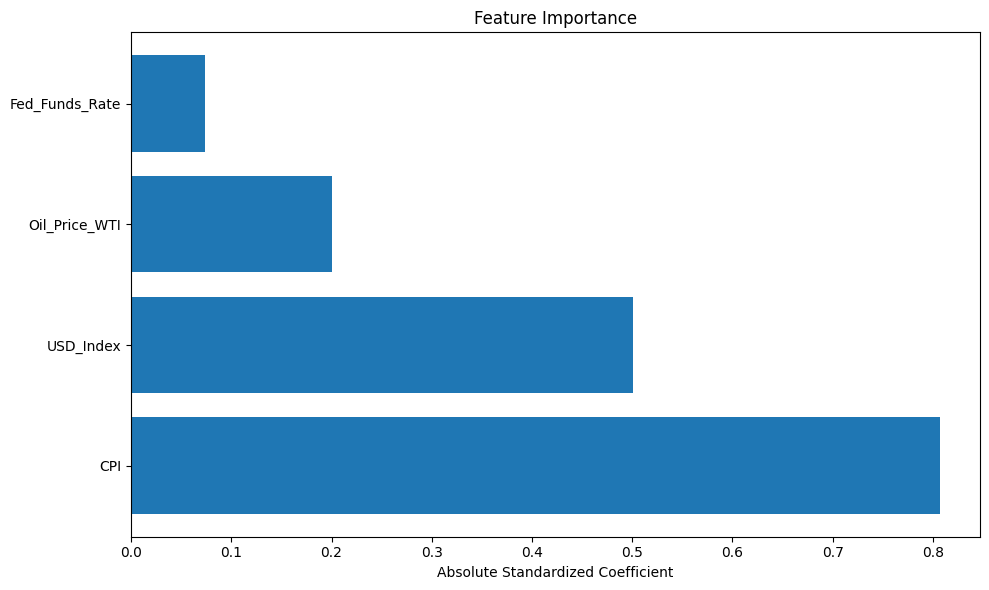

In [12]:
import pandas as pd
import numpy as np


coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_,
    'Abs_Coefficient': np.abs(model.coef_)
}).sort_values('Abs_Coefficient', ascending=False)

print("Feature Importance (by coefficient magnitude):")
print(coefficients)


X_std = X.std()
standardized_coef = model.coef_ * X_std

feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Standardized_Coefficient': standardized_coef,
    'Abs_Std_Coefficient': np.abs(standardized_coef)
}).sort_values('Abs_Std_Coefficient', ascending=False)

print("\nFeature Importance (standardized):")
print(feature_importance)


import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Abs_Std_Coefficient'])
plt.xlabel('Absolute Standardized Coefficient')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

In [13]:
import statsmodels.api as sm


X_train_with_const = sm.add_constant(X_train)


model_sm = sm.OLS(y_train, X_train_with_const).fit()


print(model_sm.summary())



print("="*60)
print(f"{'Variable':<20} {'Coefficient':<15} {'t-statistic':<15} {'p-value':<15}")
print("="*60)

for var, coef, t_stat, p_val in zip(model_sm.params.index,
                                      model_sm.params.values,
                                      model_sm.tvalues.values,
                                      model_sm.pvalues.values):
    significance = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else ""
    print(f"{var:<20} {coef:>12.6f}   {t_stat:>12.4f}   {p_val:>12.6f} {significance}")

print("\n*** p<0.001, ** p<0.01, * p<0.05")

                             OLS Regression Results                             
Dep. Variable:     Copper_Spot_Price_lb   R-squared:                       0.791
Model:                              OLS   Adj. R-squared:                  0.784
Method:                   Least Squares   F-statistic:                     117.3
Date:                  Sat, 15 Nov 2025   Prob (F-statistic):           3.53e-41
Time:                          03:13:32   Log-Likelihood:                -30.173
No. Observations:                   129   AIC:                             70.35
Df Residuals:                       124   BIC:                             84.65
Df Model:                             4                                         
Covariance Type:              nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.837

In [14]:
import pandas as pd
import numpy as np
import statsmodels.api as sm


X_train_with_const = sm.add_constant(X_train)
model_sm = sm.OLS(y_train, X_train_with_const).fit()


feature_stats = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_,
    'Abs_Coefficient': np.abs(model.coef_),
    't_statistic': model_sm.tvalues[1:].values,
    'p_value': model_sm.pvalues[1:].values,
    'Significance': ['***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else ''
                     for p in model_sm.pvalues[1:].values]
}).sort_values('Abs_Coefficient', ascending=False)

print("\nFeature Importance with Statistical Significance:")
print("="*80)
print(feature_stats.to_string(index=False))
print("\n*** p<0.001, ** p<0.01, * p<0.05")


Feature Importance with Statistical Significance:
       Feature  Coefficient  Abs_Coefficient  t_statistic      p_value Significance
     USD_Index    -0.049830         0.049830    -6.546406 1.403136e-09          ***
Fed_Funds_Rate    -0.040009         0.040009    -1.091745 2.770620e-01             
           CPI     0.025056         0.025056     7.820530 1.960103e-12          ***
 Oil_Price_WTI     0.009924         0.009924     4.367067 2.628657e-05          ***

*** p<0.001, ** p<0.01, * p<0.05


New Model


In [5]:
china_gdp = fred.get_series('CHNGDPNQDSMEI', observation_start='2010-01-01')
china_gdp = china_gdp.to_frame(name='China_GDP_Growth')

In [18]:
china_gdp = filter_dates(china_gdp)
df_combined_new = df_combined.join(china_gdp, how='left')
df_combined_new = df_combined_new.dropna()

In [22]:
df_combined_new

Copper_Spot_Price  Copper_Spot_Price_lb   USD_Index  \
2010-01-01        7367.375000              3.341789   77.840526   
2010-04-01        7729.837500              3.506199   81.232857   
2010-07-01        6750.568182              3.062010   83.070476   
2010-10-01        8289.761905              3.760177   77.459999   
2011-01-01        9533.200000              4.324192   79.146000   
2011-04-01        9482.750000              4.301308   74.724500   
2011-07-01        9650.464286              4.377382   74.757000   
2011-10-01        7394.190476              3.353952   77.154285   
2012-01-01        8061.916667              3.656828   80.268000   
2012-04-01        8285.526316              3.758256   79.401500   
2012-07-01        7584.261364              3.440167   83.067619   
2012-10-01        8062.032609              3.656881   79.708095   
2013-01-01        8053.738636              3.653119   79.873333   
2013-04-01        7221.161905              3.275468   82.525000   
2013-07-01        6906.641304              3.132804   82.789546   
2013-10-01        7203.021739              3.267240   79.866522   
2014-01-01        7291.465909              3.307357   80.809524   
2014-04-01        6673.562500              3.027081   79.853334   
2014-07-01        7113.380435              3.226579   80.547726   
2014-10-01        6737.478261              3.056072   85.670435   
2015-01-01        5830.535714              2.644690   92.977000   
2015-04-01        6042.087500              2.740648   97.591905   
2015-07-01        5456.750000              2.475143   96.962273   
2015-10-01        5216.090909              2.365982   95.714091   
2016-01-01        4471.787500              2.028371   99.023000   
2016-04-01        4872.738095              2.210239   94.403809   
2016-07-01        4864.904762              2.206686   96.572501   
2016-10-01        4731.261905              2.146067   97.738999   
2017-01-01        5754.559524              2.610227  101.122000   
2017-04-01        5683.902778              2.578178  100.045263   
2017-07-01        5985.119048              2.714808   94.861001   
2017-10-01        6807.602273              3.087880   93.719545   
2018-01-01        7065.852273              3.205020   90.744762   
2018-04-01        6851.512500              3.107797   90.293333   
2018-07-01        6250.750000              2.835296   94.597619   
2018-10-01        6219.586957              2.821161   95.852609   
2019-01-01        5939.102273              2.693935   95.937619   
2019-04-01        6438.362500              2.920396   97.358572   
2019-07-01        5941.195652              2.694884   97.365909   
2019-10-01        5757.297826              2.611469   98.173044   
2022-01-01        9782.337500              4.437199   95.966500   
2022-04-01       10174.347619              4.615012  100.708500   
2022-07-01        7544.809524              3.422272  107.033500   
2022-10-01        7651.082857              3.470477  111.941428   
2023-01-01        9007.346364              4.085668  102.711999   
2023-04-01        8809.157500              3.995771  101.764210   
2023-07-01        8476.679048              3.844962  101.327499   

            Fed_Funds_Rate      CPI  Oil_Price_WTI  China_GDP_Growth  
2010-01-01            0.11  217.488      78.325789      8.750130e+12  
2010-04-01            0.20  217.403      84.292857      9.934740e+12  
2010-07-01            0.18  217.605      76.319524      1.059637e+13  
2010-10-01            0.19  219.035      81.892857      1.193068e+13  
2011-01-01            0.17  221.187      89.170500      1.044699e+13  
2011-04-01            0.10  224.093     109.532500      1.188959e+13  
2011-07-01            0.07  225.395      97.303500      1.265622e+13  
2011-10-01            0.07  226.750      86.322381      1.380121e+13  
2012-01-01            0.08  227.842     100.273500      1.173576e+13  
2012-04-01            0.14  229.187     103.321000      1.313206e+13  
2012-07-01    

without the Fed funds rate

In [21]:
y = df_clean['Copper_Spot_Price_lb']
X = df_clean[['USD_Index', 'CPI', 'Oil_Price_WTI']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = LinearRegression()
model.fit(X_train, y_train)


y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

import statsmodels.api as sm
X_train_with_const = sm.add_constant(X_train)
model_sm = sm.OLS(y_train, X_train_with_const).fit()
print(model_sm.summary())

                             OLS Regression Results                             
Dep. Variable:     Copper_Spot_Price_lb   R-squared:                       0.789
Model:                              OLS   Adj. R-squared:                  0.784
Method:                   Least Squares   F-statistic:                     155.8
Date:                  Sun, 16 Nov 2025   Prob (F-statistic):           4.69e-42
Time:                          20:15:10   Log-Likelihood:                -30.790
No. Observations:                   129   AIC:                             69.58
Df Residuals:                       125   BIC:                             81.02
Df Model:                             3                                         
Covariance Type:              nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.1445  

without CPI


In [24]:
y = df_clean['Copper_Spot_Price_lb']
X = df_clean[['USD_Index', 'Oil_Price_WTI']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = LinearRegression()
model.fit(X_train, y_train)


y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

import statsmodels.api as sm
X_train_with_const = sm.add_constant(X_train)
model_sm = sm.OLS(y_train, X_train_with_const).fit()
print(model_sm.summary())

                             OLS Regression Results                             
Dep. Variable:     Copper_Spot_Price_lb   R-squared:                       0.577
Model:                              OLS   Adj. R-squared:                  0.570
Method:                   Least Squares   F-statistic:                     85.98
Date:                  Sun, 16 Nov 2025   Prob (F-statistic):           2.82e-24
Time:                          20:19:26   Log-Likelihood:                -75.628
No. Observations:                   129   AIC:                             157.3
Df Residuals:                       126   BIC:                             165.8
Df Model:                             2                                         
Covariance Type:              nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -1.1183  

 without CPI and then add China’s GDP growth rate

In [23]:
y = df_combined_new['Copper_Spot_Price_lb']
X = df_combined_new[['USD_Index', 'China_GDP_Growth', 'Oil_Price_WTI']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = LinearRegression()
model.fit(X_train, y_train)


y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

import statsmodels.api as sm
X_train_with_const = sm.add_constant(X_train)
model_sm = sm.OLS(y_train, X_train_with_const).fit()
print(model_sm.summary())

                             OLS Regression Results                             
Dep. Variable:     Copper_Spot_Price_lb   R-squared:                       0.545
Model:                              OLS   Adj. R-squared:                  0.503
Method:                   Least Squares   F-statistic:                     13.15
Date:                  Sun, 16 Nov 2025   Prob (F-statistic):           8.20e-06
Time:                          20:17:38   Log-Likelihood:                -17.399
No. Observations:                    37   AIC:                             42.80
Df Residuals:                        33   BIC:                             49.24
Df Model:                             3                                         
Covariance Type:              nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               